# PRMT-2711 - Cutoff days don't have a large impact on transfer outcomes

## Hypothesis
We believe cutoff days do not have a large impact on transfer outcomes.

## Date Range
February 1st-28th 2022

## Context
We want to setup alerts with closer feedback when errors occur.
In order to do that, we want to understand the changes of transfer outcomes between different cutoff days. For example, we currently run our reports on a 7-day cutoff basis, meaning we get the data up to 8 days after the transfer happens. We want to see if having 0 cut off days (no additional days of data from when the transfer started) has a large affect, and if not, we may be able to report transfers a day after they happen.
For the analysis, we want a line graph comparing a month’s worth of data for Feb with:

* 0 day cutoff
* 1 day cutoff
* 2 day cutoff
* 14 day cutoff

And how the different cutoffs affect the outcomes:
* Integrated on time
* Process failures
* Technical failures

In [2]:
import pandas as pd

def add_leading_zero(num: int) -> str:
    return str(num).zfill(2)

In [3]:
data_folder_1_day_cutoff="s3://prm-gp2gp-transfer-data-preprod/v11/cutoff-1"
transfer_parquet_files_1_day_cutoff = [f"{data_folder_1_day_cutoff}/2022/02/{add_leading_zero(day)}/2022-02-{add_leading_zero(day)}-transfers.parquet" for day in range(1, 29)]
transfers_raw_1_day_cutoff = pd.concat([pd.read_parquet(file) for file in transfer_parquet_files_1_day_cutoff])

data_folder_0_day_cutoff="s3://prm-gp2gp-transfer-data-preprod/v11/cutoff-0"
transfer_parquet_files_0_day_cutoff = [f"{data_folder_0_day_cutoff}/2022/02/{add_leading_zero(day)}/2022-02-{add_leading_zero(day)}-transfers.parquet" for day in range(1, 29)]
transfers_raw_0_day_cutoff = pd.concat([pd.read_parquet(file) for file in transfer_parquet_files_0_day_cutoff])

data_folder_2_day_cutoff="s3://prm-gp2gp-transfer-data-preprod/v11/cutoff-2"
transfer_parquet_files_2_day_cutoff = [f"{data_folder_2_day_cutoff}/2022/02/{add_leading_zero(day)}/2022-02-{add_leading_zero(day)}-transfers.parquet" for day in range(1, 29)]
transfers_raw_2_day_cutoff = pd.concat([pd.read_parquet(file) for file in transfer_parquet_files_2_day_cutoff])

In [4]:
total_transfers = transfers_raw_1_day_cutoff.shape[0]
total_transfers

197088

# Summary
### 0 Day cutoff

In [15]:
zero_day = transfers_raw_0_day_cutoff.value_counts("status")
zero_day.sort_index()

status
Integrated on time       86334
Process failure         103680
Technical failure         6501
Unclassified failure       573
dtype: int64

In [16]:
zero_day_percentage = transfers_raw_0_day_cutoff.value_counts("status").apply(lambda x: (x / total_transfers)) * 100
zero_day_percentage.sort_index()

status
Integrated on time      43.804798
Process failure         52.605943
Technical failure        3.298527
Unclassified failure     0.290733
dtype: float64

In [154]:
transfers_raw_0_day_cutoff['day'] = transfers_raw_0_day_cutoff['date_requested'].dt.to_period('D')
grouped_0_day_transfers = transfers_raw_0_day_cutoff.groupby("day").agg({'conversation_id':'count'}).reset_index()
#grouped_0_day_transfers

In [155]:
technical_failure_0_day_cutoff_bool = transfers_raw_0_day_cutoff["status"] == "Technical failure"
technical_failure_0_day_cutoff_bool = transfers_raw_0_day_cutoff[technical_failure_0_day_cutoff_bool]
grouped_technical_failure_0_day_cutoff = technical_failure_0_day_cutoff_bool.groupby("day").agg({'conversation_id':'count'}).reset_index()
#grouped_technical_failure_0_day_cutoff

In [162]:
merged_grouped_0_day_transfers = grouped_0_day_transfers.merge(grouped_technical_failure_0_day_cutoff, left_on="day", right_on="day", how="outer")
merged_grouped_0_day_transfers['percentage'] = (merged_grouped_0_day_transfers['conversation_id_y'] / merged_grouped_0_day_transfers['conversation_id_x']) * 100
merged_grouped_0_day_transfers.set_index('day')["percentage"]

day
2022-02-01    3.359556
2022-02-02    3.010293
2022-02-03    3.143398
2022-02-04    3.152425
2022-02-05    2.187500
2022-02-06    2.453988
2022-02-07    3.591295
2022-02-08    3.269780
2022-02-09    3.125000
2022-02-10    3.574788
2022-02-11    3.812825
2022-02-12    3.416149
2022-02-13    5.617978
2022-02-14    4.044279
2022-02-15    2.933698
2022-02-16    2.871336
2022-02-17    3.982108
2022-02-18    3.410029
2022-02-19    3.472222
2022-02-20    2.755906
2022-02-21    2.988898
2022-02-22    3.249759
2022-02-23    2.957690
2022-02-24    2.987013
2022-02-25    3.640580
2022-02-26    1.504630
2022-02-27    1.702128
2022-02-28    3.324129
Freq: D, Name: percentage, dtype: float64

<AxesSubplot:xlabel='day'>

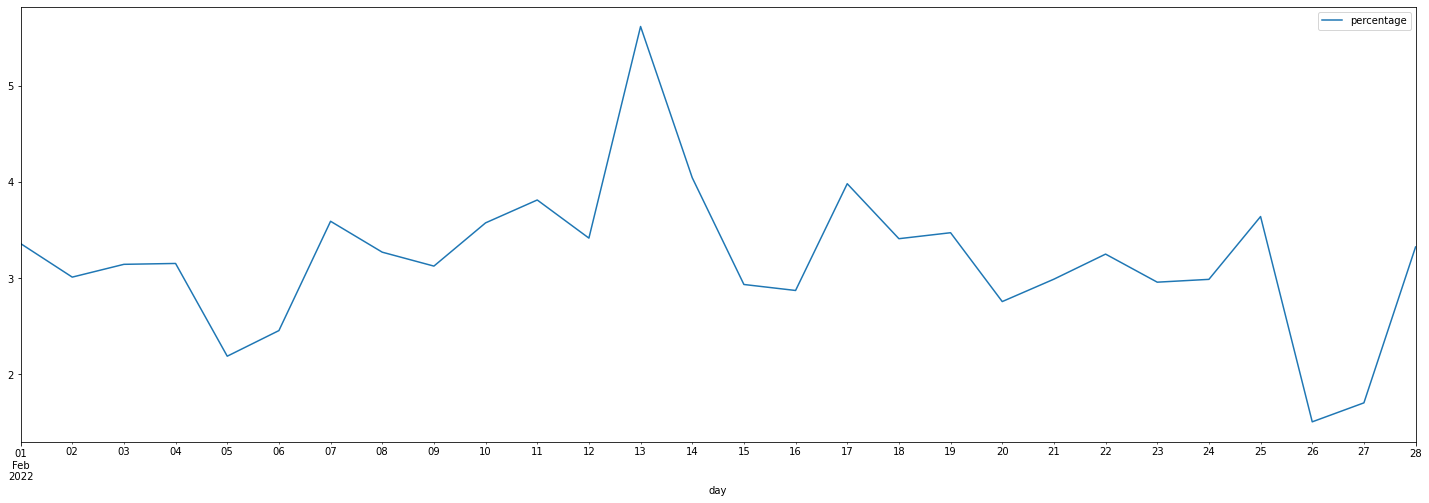

In [163]:
merged_grouped_0_day_transfers.plot(x="day", y="percentage", figsize=(25,8))

In [158]:
merged_grouped_0_day_transfers["percentage"].describe()

count    28.000000
mean      3.197835
std       0.758137
min       1.504630
25%       2.951692
50%       3.201092
75%       3.497864
max       5.617978
Name: percentage, dtype: float64

# 1 Day cutoff

In [17]:
one_day = transfers_raw_1_day_cutoff.value_counts("status")
one_day.sort_index()

status
Integrated on time      120182
Process failure          69874
Technical failure         6302
Unclassified failure       730
dtype: int64

In [18]:
one_day_percentage = transfers_raw_1_day_cutoff.value_counts("status").apply(lambda x: (x / total_transfers)) * 100
one_day_percentage.sort_index()

status
Integrated on time      60.978852
Process failure         35.453199
Technical failure        3.197556
Unclassified failure     0.370393
dtype: float64

### 2 Day cutoff

In [19]:
two_day = transfers_raw_2_day_cutoff.value_counts("status")
two_day.sort_index()

status
Integrated on time      137532
Process failure          52664
Technical failure         6187
Unclassified failure       705
dtype: int64

In [20]:
two_day_percentage = transfers_raw_2_day_cutoff.value_counts("status").apply(lambda x: (x / total_transfers)) * 100
two_day_percentage.sort_index()

status
Integrated on time      69.782026
Process failure         26.721059
Technical failure        3.139207
Unclassified failure     0.357708
dtype: float64

## Comparing 1 vs 0 day cutoff  

In [24]:
# Joining the datasets
transfers_raw_1_day_cutoff_status = transfers_raw_1_day_cutoff.copy().loc[:, ["status", "conversation_id"]]
transfers_raw_1_day_cutoff_status = transfers_raw_1_day_cutoff_status.rename({"status": "1 day cutoff"}, axis=1)
transfers_raw_0_day_cutoff_status = transfers_raw_0_day_cutoff.copy().loc[:, ["status", "conversation_id"]]
transfers_raw_0_day_cutoff_status = transfers_raw_0_day_cutoff_status.rename({"status": "0 day cutoff"}, axis=1)
new = transfers_raw_1_day_cutoff_status.merge(transfers_raw_0_day_cutoff_status, left_on="conversation_id", right_on="conversation_id", how="outer").fillna("Unknown")

### View A

In [25]:
new.groupby(by=["1 day cutoff", "0 day cutoff"]).agg("count").fillna(0).astype(int).rename({"conversation_id": "Number of transfers"}, axis=1)

Number of transfers
1 day cutoff         0 day cutoff                             
Integrated on time   Integrated on time                  86334
                     Process failure                     33545
                     Technical failure                     169
                     Unclassified failure                  134
Process failure      Process failure                     69800
                     Technical failure                      74
Technical failure    Process failure                        57
                     Technical failure                    6236
                     Unclassified failure                    9
Unclassified failure Process failure                       278
                     Technical failure                      22
                     Unclassified failure                  430

### View B

In [16]:
merged = transfers_raw_1_day_cutoff.merge(transfers_raw_0_day_cutoff, left_on="conversation_id", right_on="conversation_id", how="outer").fillna("Unknown").rename({"status_x": "1 day cutoff"}, axis=1).rename({"status_y": "0 day cutoff"}, axis=1)

In [17]:
differences = merged.value_counts(["1 day cutoff", "0 day cutoff"])
differences.apply(lambda x: (x / total_transfers)) * 100


1 day cutoff          0 day cutoff        
Integrated on time    Integrated on time      43.804798
Process failure       Process failure         35.415652
Integrated on time    Process failure         17.020316
Technical failure     Technical failure        3.164069
Unclassified failure  Unclassified failure     0.218177
                      Process failure          0.141054
Integrated on time    Technical failure        0.085748
                      Unclassified failure     0.067990
Process failure       Technical failure        0.037547
Technical failure     Process failure          0.028921
Unclassified failure  Technical failure        0.011163
Technical failure     Unclassified failure     0.004566
dtype: float64

### New failures and their reasons

In [18]:
integrated_to_technical_failure = (merged["1 day cutoff"] == "Integrated on time") & (merged["0 day cutoff"] == "Technical failure") & (merged["failure_reason_y"] != "Unknown")
integrated_to_technical_failure = merged[integrated_to_technical_failure]
integrated_to_technical_failure.value_counts("failure_reason_y")

failure_reason_y
COPC(s) not acknowledged       93
Final error                    36
Core extract not sent          18
Request not acknowledged       16
Contains fatal sender error     5
COPC(s) not sent                1
dtype: int64